In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


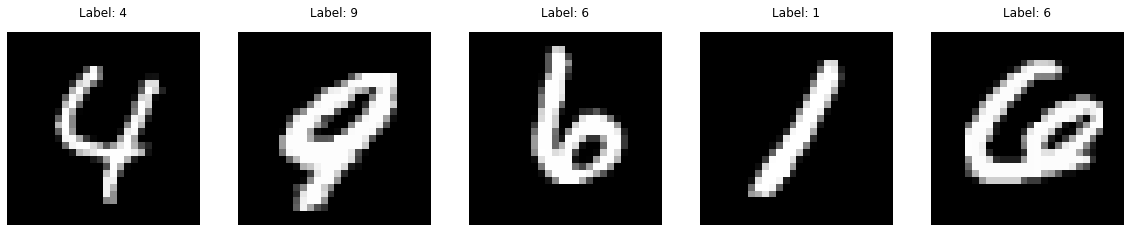

In [4]:
with np.load('mnist.npz') as npz:
    x_train, y_train, x_test, y_test = [npz[k] for k in ['x_train', 'y_train', 'x_test', 'y_test']]

fig, ax = plt.subplots(figsize=(20, 4),  ncols=5)
for a in ax:
    i = np.random.randint(x_train.shape[0])
    a.matshow(x_train[i], cmap='gray')
    a.set_title(f'Label: {y_train[i]}')
    a.axis('off')
    
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

In [5]:
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

print(f'x_train shape after reshape: {x_train.shape}')
print(f'x_test shape after reshape: {x_test.shape}')

x_train shape after reshape: (60000, 784)
x_test shape after reshape: (10000, 784)


In [6]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [18]:
class LogisticRegression:
    def __init__(
        self,
        alpha1,
        alpha2,
        learning_rate,
        batch_size,
        train_steps
    ):
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_steps = train_steps
    
    def preprocess(self, x):
        x_proc = np.concatenate([
                  np.ones((x.shape[0], 1)),
                  x
        ], axis = 1)
        return x_proc
    
    def onehot(self, y):
        y_proc = np.zeros((y.size, y.max() + 1))
        y_proc[np.arange(y.size), y] = 1
        return y_proc
    
    def normalize(self, x):
        return (x - self.mu) / self.sigma 

    def moments(self, x):
        mu = np.mean(x[:, 1:], axis = 0)
        mu = np.concatenate(([0], mu))
        sigma = np.std(x[:, 1:], axis = 0)
        sigma[sigma == 0] = 1e-8
        sigma = np.concatenate(([1], sigma))
        return mu, sigma
    
    def J(self, x, y, theta):
        theta_shlyapa = theta[1:]
        h_val = self.sh(x, theta)
        j = (-y * np.log(h_val) - (1 - y)).mean() + self.alpha1 * np.sum(np.absolute(theta_shlyapa)) + self.alpha2 * np.sum(theta_shlyapa ** 2)
        return j
    
    def h(self, x, theta):
        return 1 / (1 + np.exp(-x @ theta))
    
    def grad(self, x, y, theta):
        i_m = np.identity(theta.shape[0])
        i_m[0,0] = 0
        return -1 * x.T @ (y - self.h(x, theta)) / x.shape[0] + i_m @ (self.alpha1 * np.sign(theta) + 2 * self.alpha2 * theta)
    
    def get_batch(self, x, y):
        perm = np.random.permutation(x.shape[0])[:self.batch_size]
        return x[perm], y[perm]
    
    def fit(self, x, y):
        x = self.preprocess(x)
        # print(x)
        y = self.onehot(y)
        # print(y)

        (m, n), (_, c) = x.shape, y.shape
        
        self.mu, self.sigma = self.moments(x)
        x = self.normalize(x)
        
        theta = np.zeros(shape=(n, c))
        v_1 = theta
        v_t = v_1
        for step in range(self.train_steps):
            x_batch, y_batch = self.get_batch(x, y)
            theta_grad = self.grad(x_batch, y_batch, theta)

            # TODO Update v_t and theta
            v_t = 0.9 * v_t + self.learning_rate * theta_grad
            theta -= v_t 

        self.theta = theta
        
        return self

    def predict(self, x):
        x = self.preprocess(x)
        x = self.normalize(x)
        return self.h(x, self.theta).argmax(axis=1)
    
    def score(self, x, y):
        y_pred = self.predict(x)
        return (y == y_pred).mean()

In [24]:
reg = LogisticRegression(0, 0, 1e-3, 32, 1000).fit(x_train, y_train)
print(f'Test accuracy: {reg.score(x_test, y_test) * 100}%')

Test accuracy: 87.33999999999999%


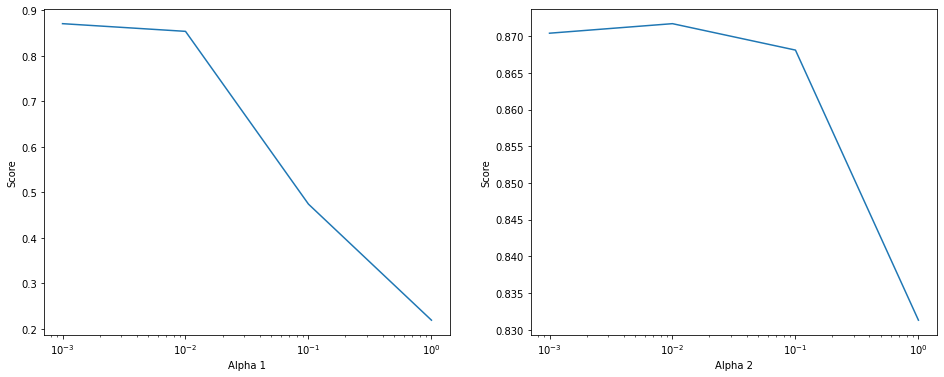

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ax[0].set_xlabel('Alpha 1')
ax[0].set_ylabel('Score')
ax[0].set_xscale('log')
ax[0].plot([1e-3, 1e-2, 1e-1, 1], [
                                   LogisticRegression(1e-3, 0, 1e-3, 32, 1000).fit(x_train, y_train).score(x_test, y_test), 
                                   LogisticRegression(1e-2, 0, 1e-3, 32, 1000).fit(x_train, y_train).score(x_test, y_test),
                                   LogisticRegression(1e-1, 0, 1e-3, 32, 1000).fit(x_train, y_train).score(x_test, y_test),
                                   LogisticRegression(1, 0, 1e-3, 32, 1000).fit(x_train, y_train).score(x_test, y_test)
                                   ])
ax[1].set_xlabel('Alpha 2')
ax[1].set_ylabel('Score')
ax[1].set_xscale('log')
ax[1].plot([1e-3, 1e-2, 1e-1, 1], [
                                   LogisticRegression(0, 1e-3, 1e-3, 32, 1000).fit(x_train, y_train).score(x_test, y_test), 
                                   LogisticRegression(0, 1e-2, 1e-3, 32, 1000).fit(x_train, y_train).score(x_test, y_test),
                                   LogisticRegression(0, 1e-1, 1e-3, 32, 1000).fit(x_train, y_train).score(x_test, y_test),
                                   LogisticRegression(0, 1, 1e-3, 32, 1000).fit(x_train, y_train).score(x_test, y_test)
                                   ])
plt.show()

In [13]:
results = [[], [], [], []]
best_scrore = 0
best_a1 = 0
best_a2 = 0
for a1 in enumerate([1e-3, 1e-2, 1e-1, 1]):
    for a2 in enumerate([1e-3, 1e-2, 1e-1, 1]):
        reg = LogisticRegression(a1[1], a2[1], 1e-3, 1024, 1000).fit(x_train, y_train)
        result = reg.score(x_test, y_test)
        results[a1[0]].append(result)
        if result > best_scrore:
          best_a1 = a1[1]
          best_a2 = a2[1]
          best_scrore = result


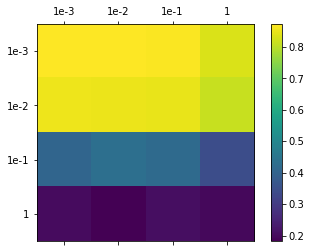

In [14]:
alphabets = ['1e-3', '1e-2', '1e-1', '1',]
 
figure = plt.figure()
axes = figure.add_subplot(111)
 
# using the matshow() function
caxes = axes.matshow(results, interpolation ='nearest')
figure.colorbar(caxes)
 
axes.set_xticklabels(['']+alphabets)
axes.set_yticklabels(['']+alphabets)
 
plt.show()

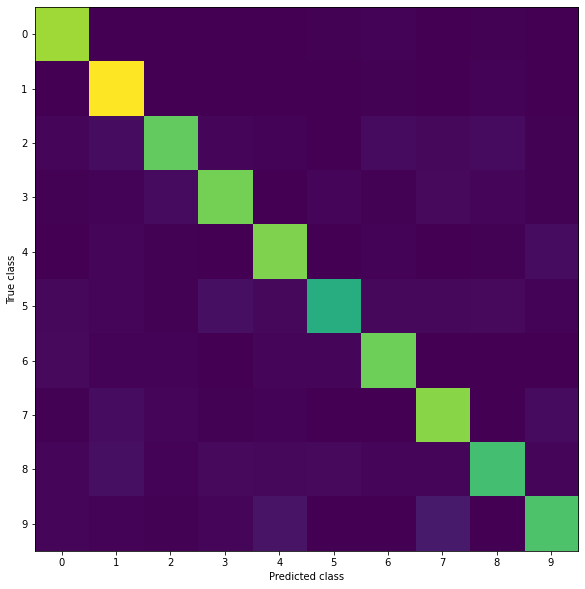

Final accuracy 87.42%


In [27]:
from sklearn.metrics import confusion_matrix

reg = LogisticRegression(best_a1, best_a2, 1e-3, 32, 1000).fit(x_train, y_train)
y_test_pred = reg.predict(x_test)

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

print(f'Final accuracy {reg.score(x_test, y_test) * 100}%')